# Pruebas Previo al Informe Final

In [1]:
# Librerías generales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Librerías especificas
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyRegressor


import warnings
warnings.filterwarnings('ignore')

/home/diego/.local/lib/python3.8/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
# cargamos los datasets
df_train = pd.read_csv('../data/df_train.csv')
df_test = pd.read_csv('../data/df_test.csv')

In [3]:
# copias para trabajar
train_raw = df_train.copy()
test_raw = df_test.copy()

## EDA PARTE 1

In [4]:
# información general de los dataframes
print("Dimensiones Entrenamiento: ", train_raw.shape)
print("Dimensiones Test: ", test_raw.shape)
print("Columnas Entrenamiento: ", train_raw.columns)
print("Columnas Test: ", test_raw.columns)

Dimensiones Entrenamiento:  (11046, 18)
Dimensiones Test:  (4734, 17)
Columnas Entrenamiento:  Index(['id', 'categoria', 'edad', 'genero', 'estado_civil',
       'ingreso_reportado', 'maximo_dias_mora', 'saldo_total',
       'saldo_productos_activos', 'saldo_productos_pasivos',
       'cantidad_productos_activos', 'cantidad_productos_pasivos',
       'saldo_en_competencia', 'monto_credito', 'plazo_credito',
       'calificacion_crediticia', 'garantia_credito', 'tasa_interes'],
      dtype='object')
Columnas Test:  Index(['id', 'categoria', 'edad', 'genero', 'estado_civil',
       'ingreso_reportado', 'maximo_dias_mora', 'saldo_total',
       'saldo_productos_activos', 'saldo_productos_pasivos',
       'cantidad_productos_activos', 'cantidad_productos_pasivos',
       'saldo_en_competencia', 'monto_credito', 'plazo_credito',
       'calificacion_crediticia', 'garantia_credito'],
      dtype='object')


In [5]:
# tipos de datos y valores nulos - Entrenamiento
print("Entrenamiento: ")
train_raw.info()

Entrenamiento: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11046 entries, 0 to 11045
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          11046 non-null  int64  
 1   categoria                   11046 non-null  object 
 2   edad                        11046 non-null  float64
 3   genero                      11046 non-null  object 
 4   estado_civil                11046 non-null  object 
 5   ingreso_reportado           9521 non-null   float64
 6   maximo_dias_mora            11046 non-null  float64
 7   saldo_total                 11046 non-null  float64
 8   saldo_productos_activos     11046 non-null  float64
 9   saldo_productos_pasivos     11046 non-null  float64
 10  cantidad_productos_activos  11046 non-null  float64
 11  cantidad_productos_pasivos  11046 non-null  float64
 12  saldo_en_competencia        9561 non-null   float64
 13  monto_credito  

In [6]:
# tipos de datos y valores nulos - Test
print("Test: ")
test_raw.info()

Test: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4734 entries, 0 to 4733
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          4734 non-null   int64  
 1   categoria                   4734 non-null   object 
 2   edad                        4734 non-null   float64
 3   genero                      4734 non-null   object 
 4   estado_civil                4734 non-null   object 
 5   ingreso_reportado           4087 non-null   float64
 6   maximo_dias_mora            4734 non-null   float64
 7   saldo_total                 4734 non-null   float64
 8   saldo_productos_activos     4734 non-null   float64
 9   saldo_productos_pasivos     4734 non-null   float64
 10  cantidad_productos_activos  4734 non-null   float64
 11  cantidad_productos_pasivos  4734 non-null   float64
 12  saldo_en_competencia        4116 non-null   float64
 13  monto_credito             

In [7]:
# unicidad de los IDs
id_train_unique = train_raw['id'].is_unique
id_test_unique = test_raw['id'].is_unique
overlap_ids = len(set(train_raw['id']).intersection(set(test_raw['id'])))

In [8]:
# vemos el solapamiento y la unicidad de los IDs
{"id_train_unique": id_train_unique, "id_test_unique": id_test_unique, "overlap_ids": overlap_ids}

{'id_train_unique': True, 'id_test_unique': True, 'overlap_ids': 0}

In [9]:
# selección de columnas numéricas y categóricas (dtype)
num_cols = train_raw.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in train_raw.columns if c not in num_cols]

In [10]:
# OBJETIVO
target_col = 'tasa_interes'
if target_col in num_cols:
    num_cols.remove(target_col)

In [11]:
# vemos los dos conjuntos de columnas
print("Columnas numéricas: ", num_cols)
print("Columnas categóricas: ", cat_cols)

Columnas numéricas:  ['id', 'edad', 'ingreso_reportado', 'maximo_dias_mora', 'saldo_total', 'saldo_productos_activos', 'saldo_productos_pasivos', 'cantidad_productos_activos', 'cantidad_productos_pasivos', 'saldo_en_competencia', 'monto_credito', 'plazo_credito', 'calificacion_crediticia']
Columnas categóricas:  ['categoria', 'genero', 'estado_civil', 'garantia_credito']


In [12]:
# Estadísticas descriptivas entrenamiento
train_num_desc = train_raw[num_cols + [target_col]].describe().T
train_num_desc

,count,mean,std,min,25%,50%,75%,max
id,11046.0,5.484397e+05,2.608121e+05,100188.000000,325022.75,542807.00,773766.75,9.999860e+05
edad,11046.0,2.461793e+10,2.587160e+12,10.000000,37.00,43.00,51.00,2.719104e+14
ingreso_reportado,9521.0,9.293208e+04,5.713371e+04,9193.487233,55312.00,86639.00,106581.00,6.550780e+05
maximo_dias_mora,11046.0,2.931939e+01,6.129397e+01,0.000000,5.00,13.00,29.00,1.209000e+03
saldo_total,11046.0,8.652327e+05,1.506142e+06,1251.000000,221773.00,491759.00,989741.75,5.398842e+07
saldo_productos_activos,11046.0,6.832633e+05,1.160252e+06,16.000000,163652.00,401201.50,838983.50,5.236306e+07
saldo_productos_pasivos,11046.0,1.819694e+05,7.795588e+05,0.000000,10809.25,29075.00,77868.75,1.503346e+07
cantidad_productos_activos,11046.0,6.188805e+11,6.469019e+13,0.000000,2.00,3.00,4.00,6.798859e+15
cantidad_productos_pasivos,11046.0,1.687976e+00,1.357290e+00,0.000000,1.00,1.00,2.00,1.200000e+01
saldo_en_competencia,9561.0,6.466455e+08,6.022617e+10,37.970000,120019.40,342419.75,793813.23,5.881630e+12


In [13]:
# Estadísticas describptivas test
test_raw_num_desc = test_raw[num_cols].describe().T
test_raw_num_desc

,count,mean,std,min,25%,50%,75%,max
id,4734.0,5.499640e+05,2.585474e+05,100099.00,331096.25,554148.500,773689.7500,9.996820e+05
edad,4734.0,5.502683e+01,5.907235e+02,19.00,37.00,44.000,51.0000,3.953800e+04
ingreso_reportado,4087.0,9.276790e+04,5.615921e+04,13136.00,55807.50,86728.000,106684.5000,6.059570e+05
maximo_dias_mora,4734.0,3.187664e+01,8.205075e+01,0.00,5.00,13.000,29.0000,3.044000e+03
saldo_total,4734.0,8.456500e+05,1.382811e+06,897.00,217739.50,481701.000,950236.0000,2.300543e+07
saldo_productos_activos,4734.0,6.515225e+05,9.362243e+05,121.00,157162.00,397054.000,808101.7500,2.036984e+07
saldo_productos_pasivos,4734.0,1.941274e+05,9.284757e+05,0.00,10230.25,29161.000,79166.7500,1.856328e+07
cantidad_productos_activos,4734.0,3.165528e+12,2.054962e+14,0.00,2.00,3.000,4.0000,1.412506e+16
cantidad_productos_pasivos,4734.0,1.697461e+00,1.408026e+00,0.00,1.00,1.000,2.0000,1.500000e+01
saldo_en_competencia,4116.0,1.110665e+06,1.653741e+07,94.29,114745.12,352990.825,800097.8125,9.779364e+08


In [14]:
# cardinalidad de variables categóricas
def cat_cardinality(df: pd.DataFrame, cats: list) -> pd.DataFrame:
    rows = []
    for c in cats:
        vc = df[c].astype("object").nunique(dropna=True)
        rows.append((c, vc))
    return pd.DataFrame(rows, columns=["col", "n_unique"]).sort_values("n_unique", ascending=False)

In [15]:
# Catdinalidad de variables categóricas entrenamiento
train_cat_card = cat_cardinality(train_raw, cat_cols)
train_cat_card

,col,n_unique
3,garantia_credito,6
2,estado_civil,4
0,categoria,3
1,genero,2


In [16]:
# Cardinalidad de variables categóricas test
test_cat_card  = cat_cardinality(test_raw,  [c for c in cat_cols if c in test_raw.columns])
test_cat_card

,col,n_unique
3,garantia_credito,6
2,estado_civil,4
0,categoria,3
1,genero,2


In [17]:
# ruta de figuras
plots_dir = r'../img/'

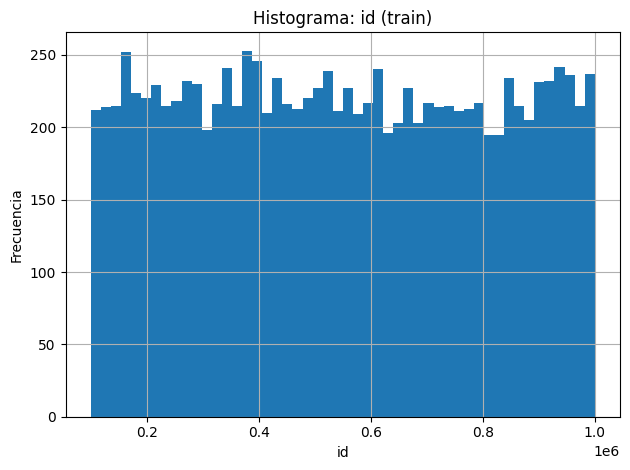

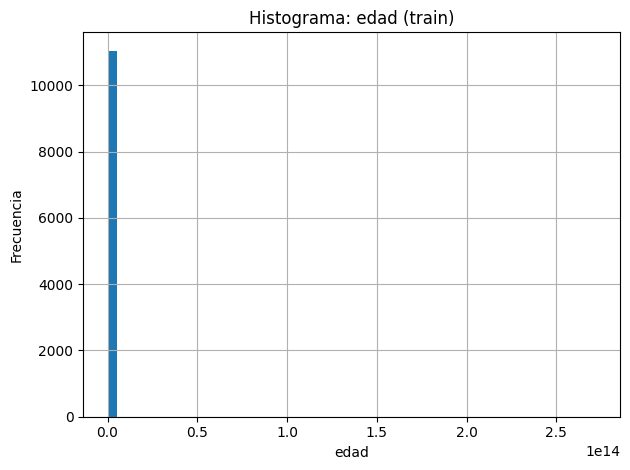

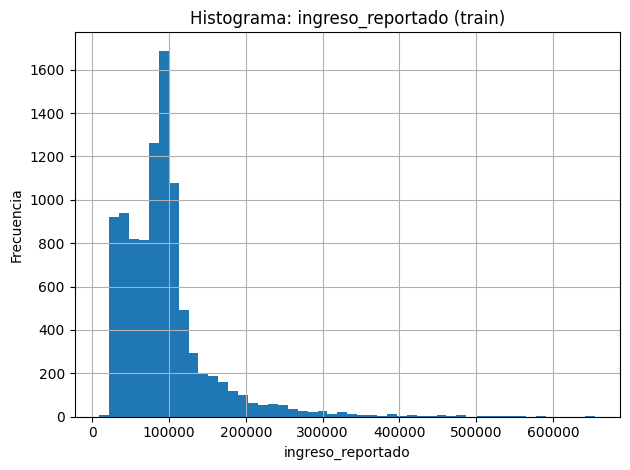

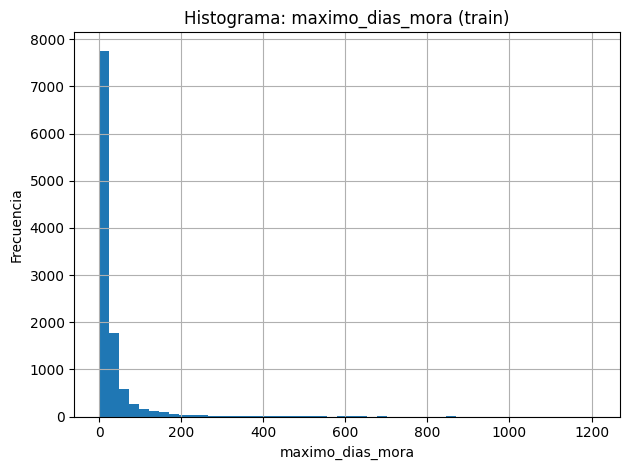

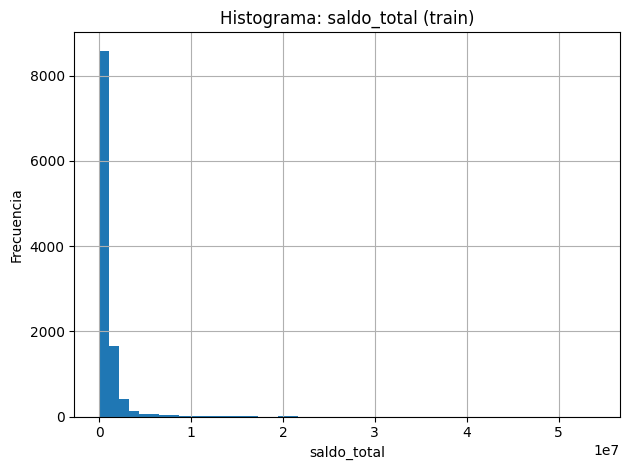

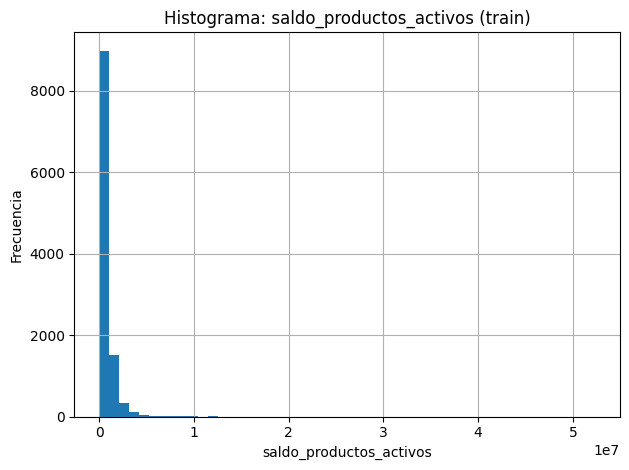

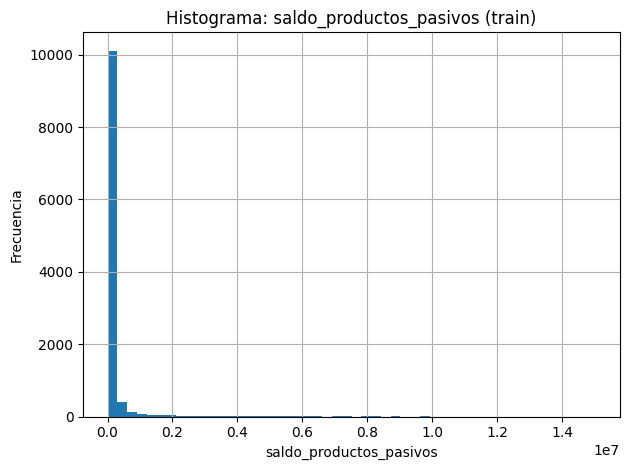

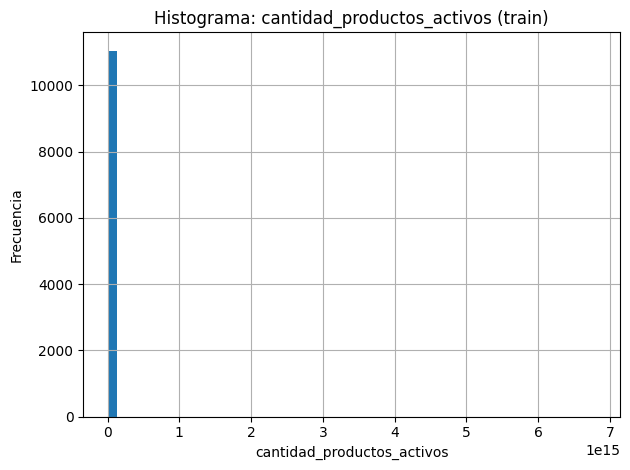

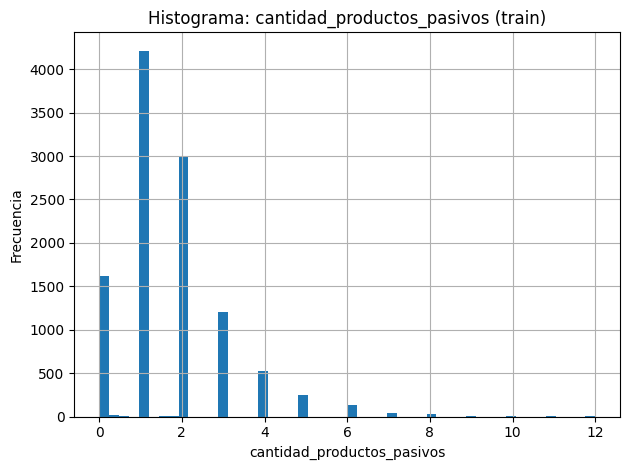

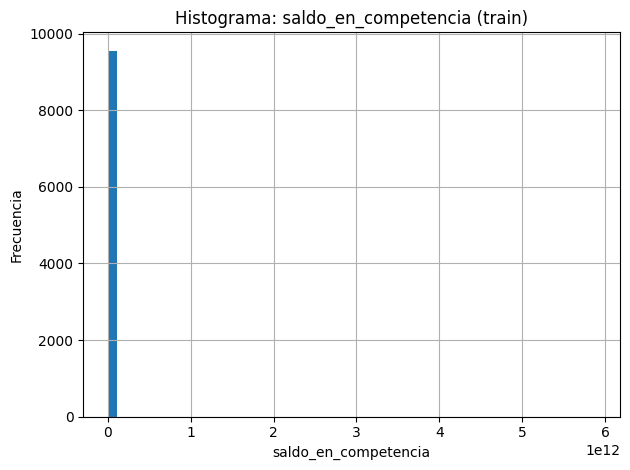

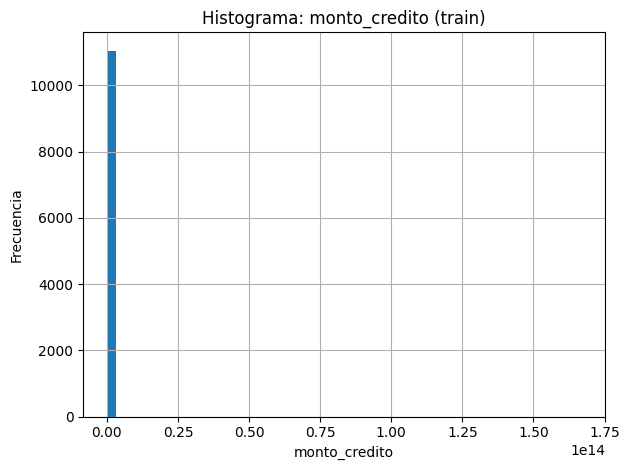

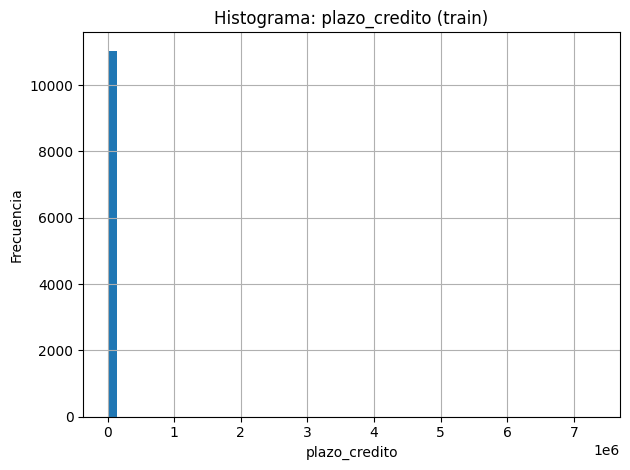

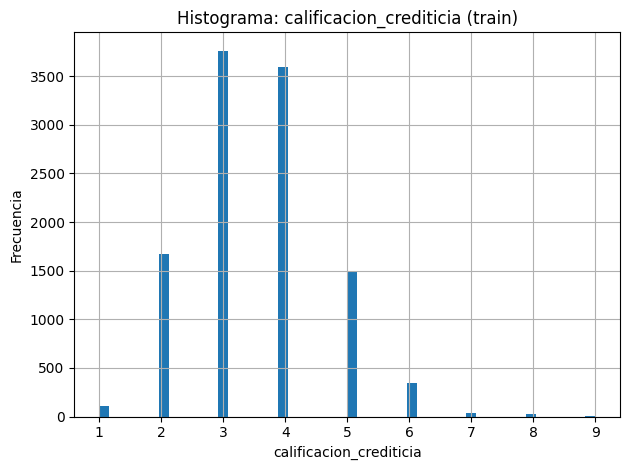

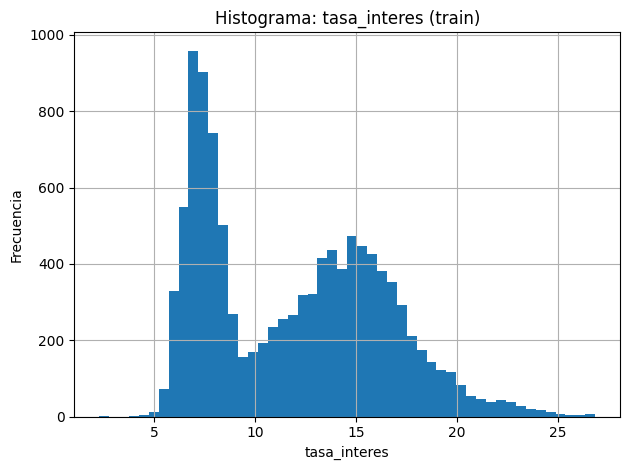

In [18]:
# Distribuciones univariadas en el dataset de entrenamiento
for c in num_cols + [target_col]:
    plt.figure()
    train_raw[c].dropna().hist(bins=50)
    plt.title(f"Histograma: {c} (train)")
    plt.xlabel(c)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.savefig(plots_dir + f"hist_train_{c}.png")
    plt.show()

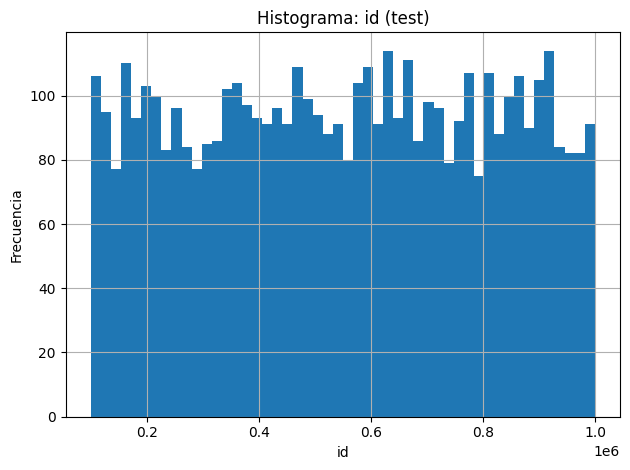

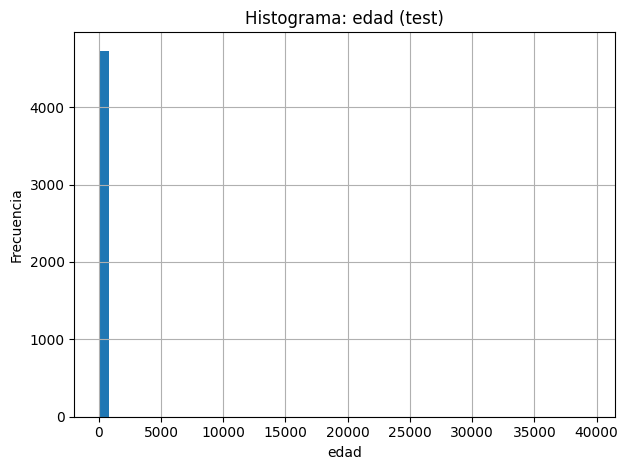

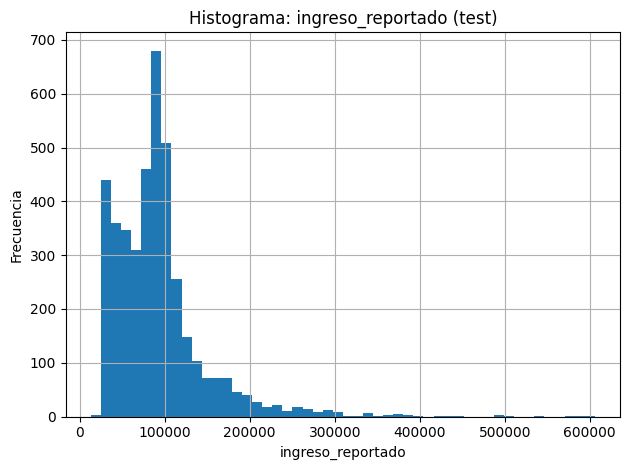

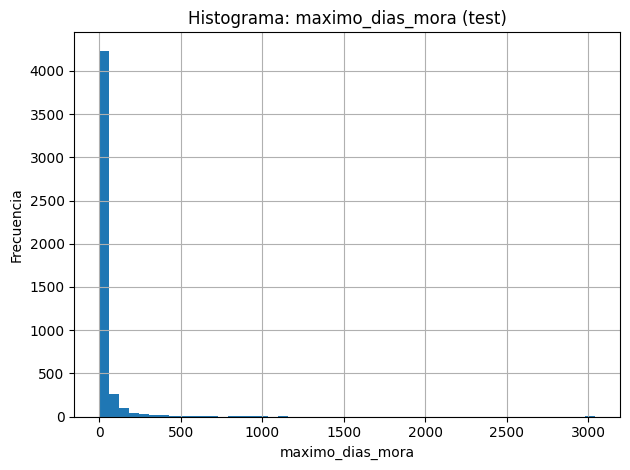

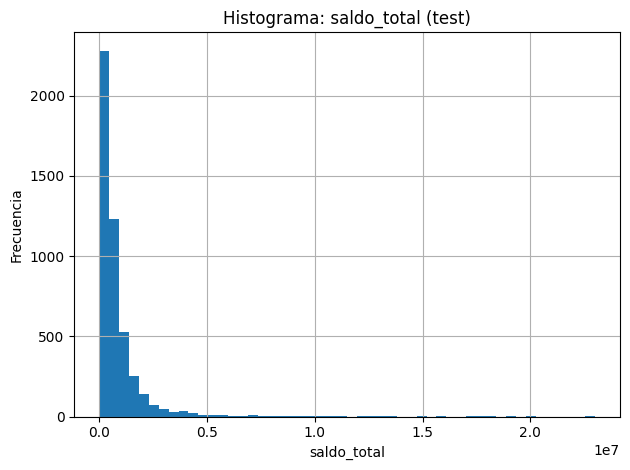

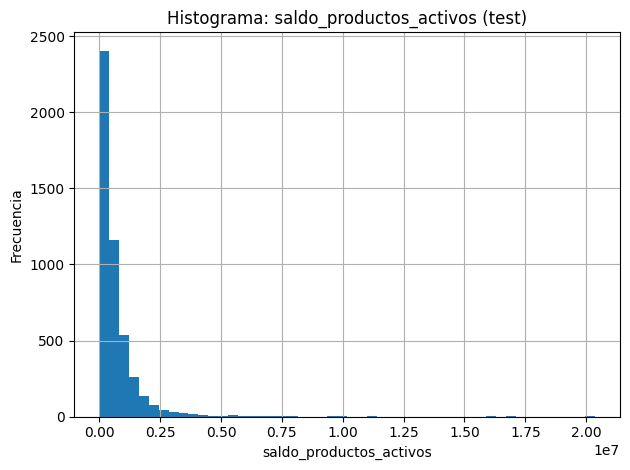

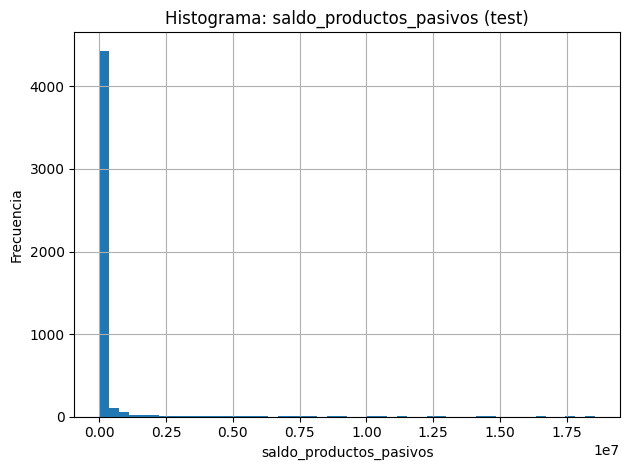

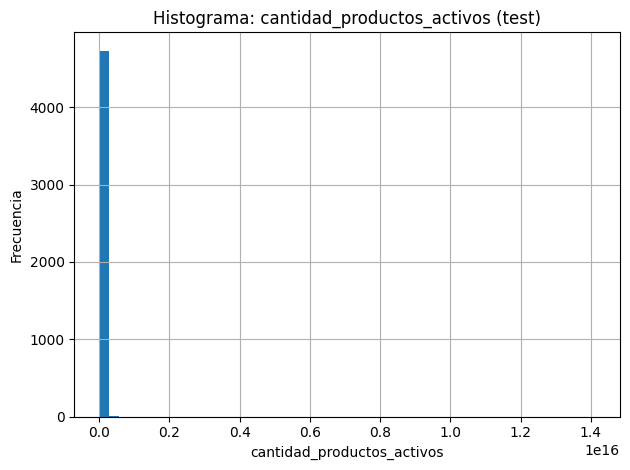

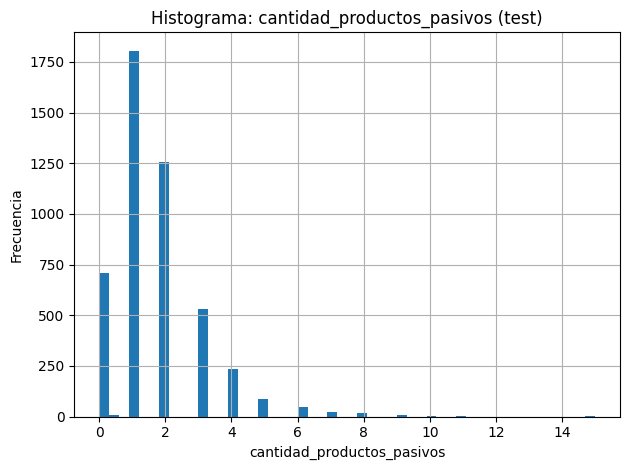

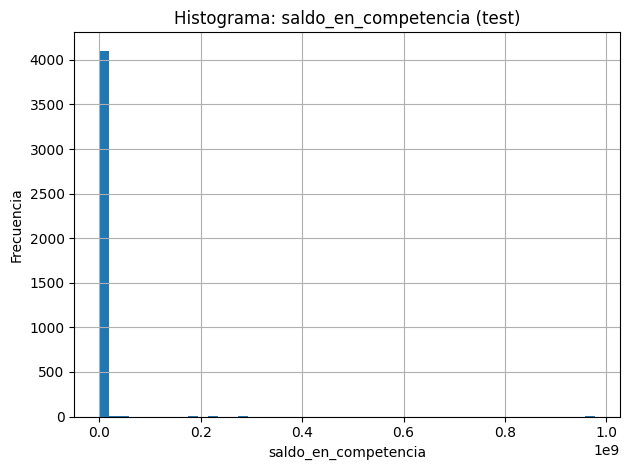

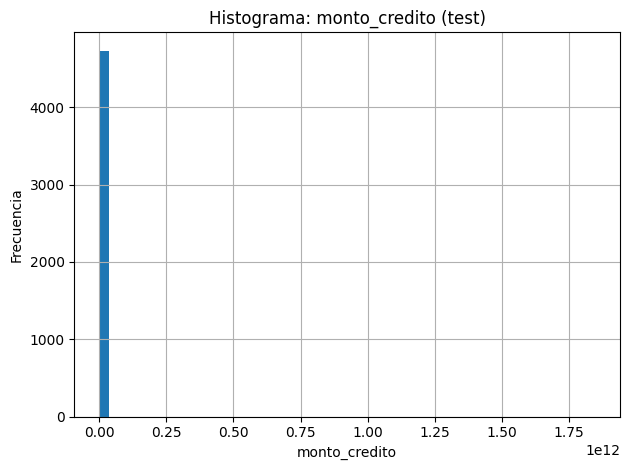

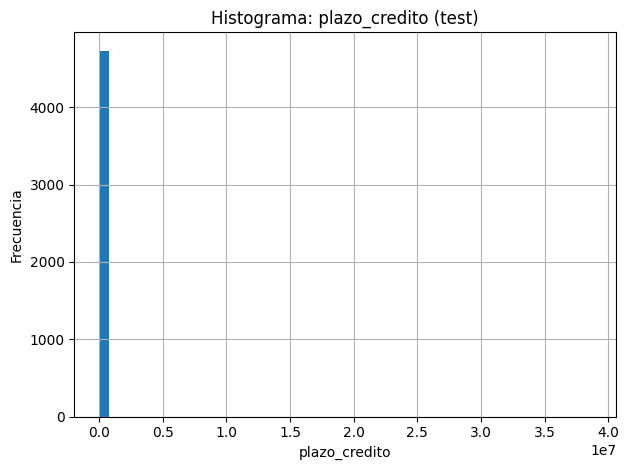

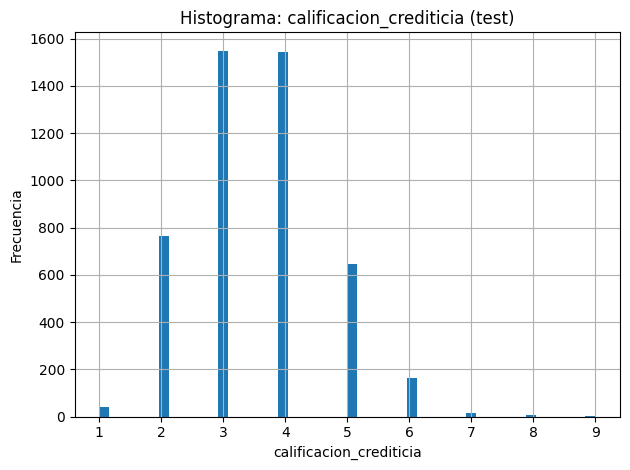

In [19]:
# Distribuciones univariadas en el dataset de entrenamiento
for c in [col for col in num_cols if col in test_raw.columns]:
    plt.figure()
    test_raw[c].dropna().hist(bins=50)
    plt.title(f"Histograma: {c} (test)")
    plt.xlabel(c)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.savefig(plots_dir + f"hist_train_{c}.png")
    plt.show()

<Figure size 640x480 with 0 Axes>

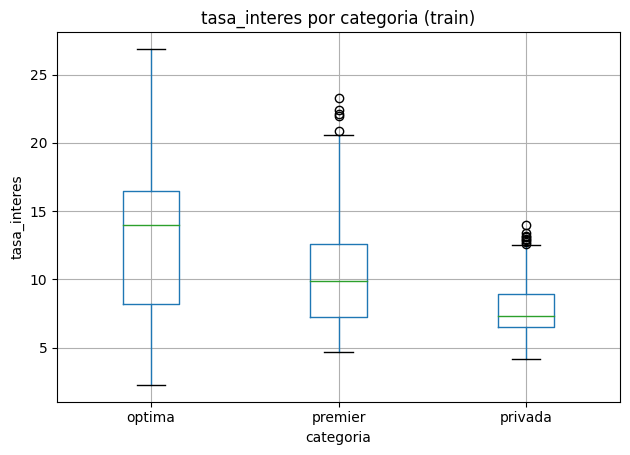

<Figure size 640x480 with 0 Axes>

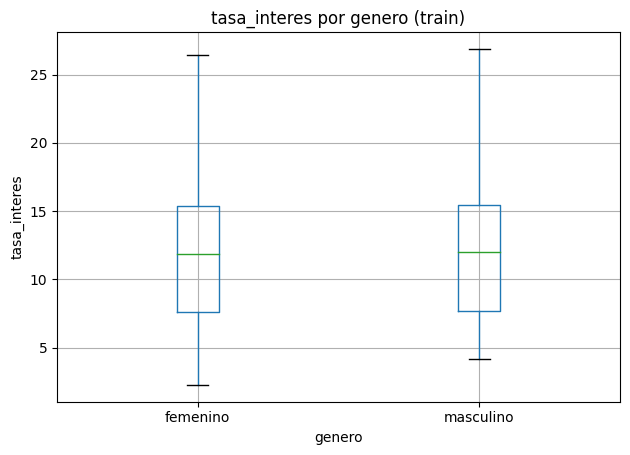

<Figure size 640x480 with 0 Axes>

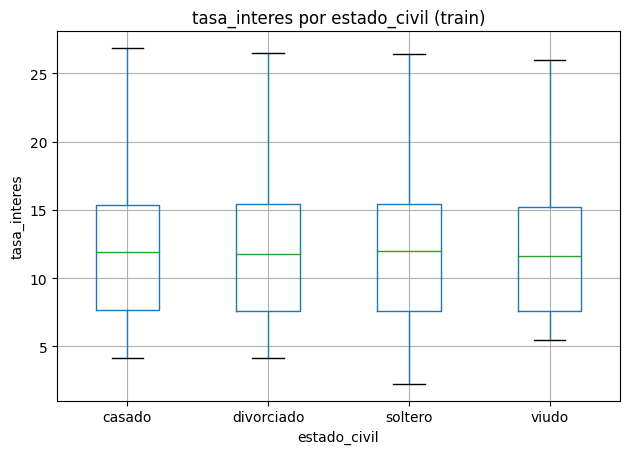

<Figure size 640x480 with 0 Axes>

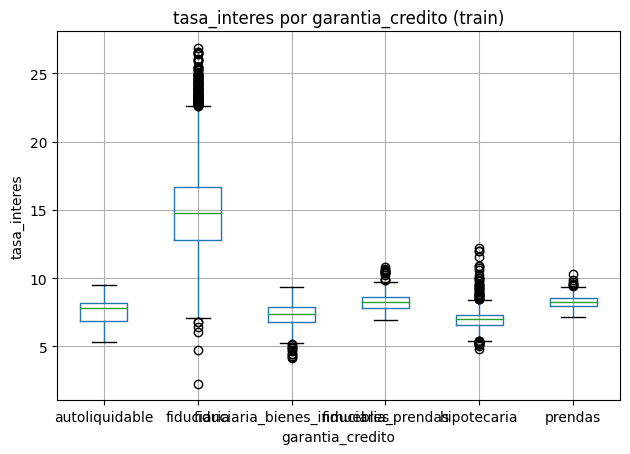

In [20]:
# Boxplotsde tasa por categoría clave
boxplot_cols = [c for c in ["categoria", "genero", "estado_civil", "garantia_credito"] if c in train_raw.columns]

for c in boxplot_cols:
    plt.figure()
    train_raw[[c, target_col]].dropna().boxplot(by=c)
    plt.suptitle("")
    plt.title(f"{target_col} por {c} (train)")
    plt.xlabel(c)
    plt.ylabel(target_col)
    plt.tight_layout()
    plt.savefig(plots_dir + f"box_tasa_por_{c}.png")
    plt.show()

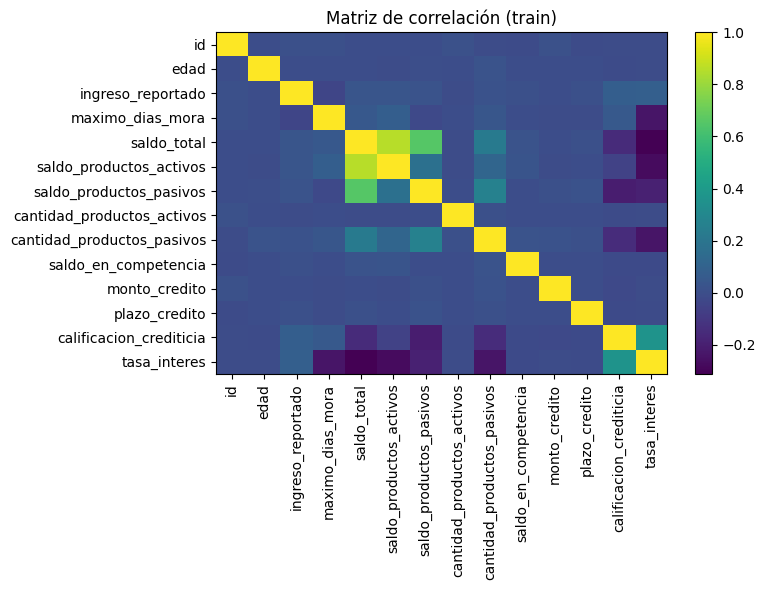

In [21]:
# Matriz de correlaciones en el dataset de entrenamiento (numéricas)
corr = train_raw[num_cols + [target_col]].corr(numeric_only=True)
plt.figure(figsize=(8,6))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Matriz de correlación (train)")
plt.tight_layout()
plt.savefig(plots_dir + f"corr_train.png")
plt.show()

In [22]:
# Comparación de distribuciones (train vs test) para numéricas compartidas
common_num = [c for c in num_cols if c in test_raw.columns]
drift_summary = []
for c in common_num:
    tr = train_raw[c].dropna()
    te = test_raw[c].dropna()
    # Resumen robusto
    row = {
        "col": c,
        "train_median": np.nanmedian(tr),
        "test_median":  np.nanmedian(te),
        "train_p95":    np.nanpercentile(tr, 95) if len(tr)>0 else np.nan,
        "test_p95":     np.nanpercentile(te, 95) if len(te)>0 else np.nan,
        "train_missing_pct": train_raw[c].isna().mean()*100,
        "test_missing_pct":  test_raw[c].isna().mean()*100
    }
    drift_summary.append(row)

drift_df = pd.DataFrame(drift_summary).sort_values("col")
drift_df

,col,train_median,test_median,train_p95,test_p95,train_missing_pct,test_missing_pct
12,calificacion_crediticia,3.00,4.000,5.00,5.000,0.000000,0.000000
7,cantidad_productos_activos,3.00,3.000,6.00,5.000,0.000000,0.000000
8,cantidad_productos_pasivos,1.00,1.000,4.00,4.000,0.000000,0.000000
1,edad,43.00,44.000,63.00,64.000,0.000000,0.000000
0,id,542807.00,554148.500,956749.25,949565.100,0.000000,0.000000
2,ingreso_reportado,86639.00,86728.000,198323.00,193636.900,13.805903,13.667089
3,maximo_dias_mora,13.00,13.000,110.00,118.700,0.000000,0.000000
10,monto_credito,246000.00,239000.000,1431750.00,1417200.000,0.000000,0.000000
11,plazo_credito,61.00,60.000,299.00,298.000,0.000000,0.000000
9,saldo_en_competencia,342419.75,352990.825,2252785.49,2227383.135,13.443781,13.054499


## Limpieza y Preprocesamiento

In [23]:
# nuevas copias para modificaciones
train = train_raw.copy()
test = test_raw.copy()

In [24]:
# vemos los dos conjuntos de columnas
print("Columnas numéricas: ", num_cols)
print("Columnas categóricas: ", cat_cols)

Columnas numéricas:  ['id', 'edad', 'ingreso_reportado', 'maximo_dias_mora', 'saldo_total', 'saldo_productos_activos', 'saldo_productos_pasivos', 'cantidad_productos_activos', 'cantidad_productos_pasivos', 'saldo_en_competencia', 'monto_credito', 'plazo_credito', 'calificacion_crediticia']
Columnas categóricas:  ['categoria', 'genero', 'estado_civil', 'garantia_credito']


In [25]:
# Separamos las columnas de montos
money_like = [c for c in [
    "ingreso_reportado", "saldo_total", "saldo_productos_activos", "saldo_productos_pasivos",
    "saldo_en_competencia", "monto_credito"
] if c in train.columns]

# Separamos las columnas de conteos
count_like = [c for c in [
    "cantidad_productos_activos", "cantidad_productos_pasivos", "maximo_dias_mora", "plazo_credito"
] if c in train.columns]

In [26]:
# Procedimineto de imputación simple (mediana)
def impute_simple(df: pd.DataFrame, num_cols: list, cat_cols: list) -> pd.DataFrame:
    df = df.copy()
    for c in num_cols:
        if c in df.columns:
            med = df[c].median()
            df[c] = df[c].fillna(med)
    for c in cat_cols:
        if c in df.columns:
            mode = df[c].mode(dropna=True)
            if len(mode)>0:
                df[c] = df[c].fillna(mode.iloc[0])
            else:
                df[c] = df[c].fillna("desconocido")
    return df

In [27]:
# Aplicamos la imputación
train_imp = impute_simple(df=train, num_cols=num_cols, cat_cols=cat_cols)
test_imp = impute_simple(df=test, num_cols=num_cols, cat_cols=cat_cols)

In [28]:
# Winsorización (1% - 99%) en numéricas (excepto id y objetivo)
def winsorize(df: pd.DataFrame, cols: list, lower: float = 0.01, upper: float = 0.99) -> pd.DataFrame:
    df = df.copy()
    for c in cols:
        if c in df.columns and c not in ["id", target_col]:
            lo, hi = df[c].quantile(lower), df[c].quantile(upper)
            df[c] = df[c].clip(lo, hi)
    return df

In [29]:
# Aplicamos la función
train_win = winsorize(train_imp, num_cols)
test_win  = winsorize(test_imp,  [c for c in test_imp.select_dtypes(include=[np.number]).columns])

In [30]:
# Aplicamos la transformación log(x + 1) a las columnas de montos
def add_log1p(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[f"log1p_{c}"] = np.log1p(df[c].clip(lower=0))
    return df

In [31]:
# Aplicamos la función
train_feat = add_log1p(df=train_win, cols=money_like)
test_feat = add_log1p(df=test_win, cols=money_like)

## EDA PARTE 2

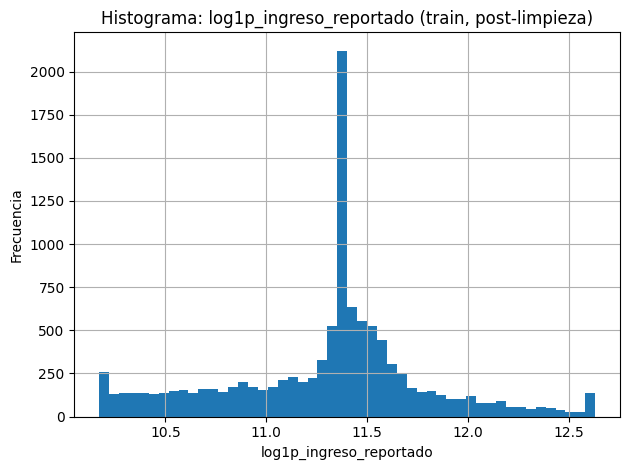

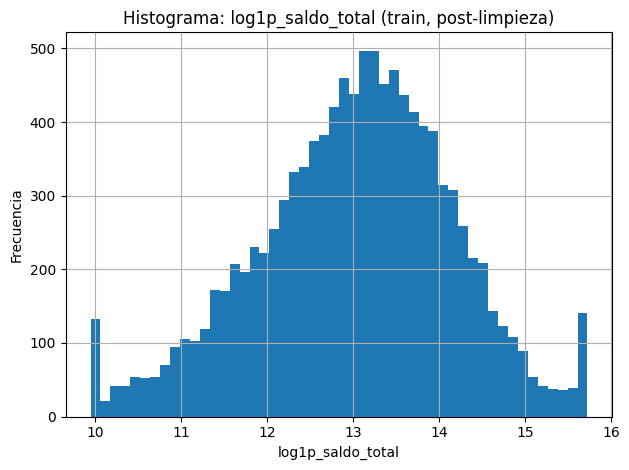

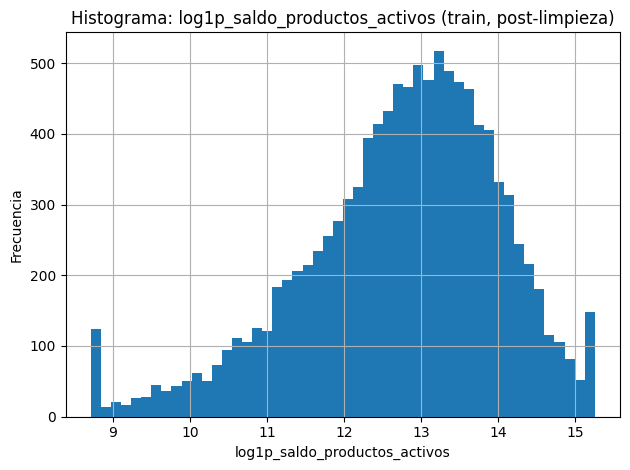

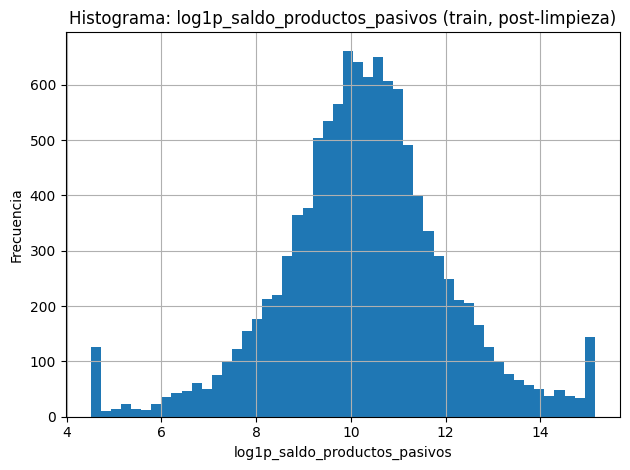

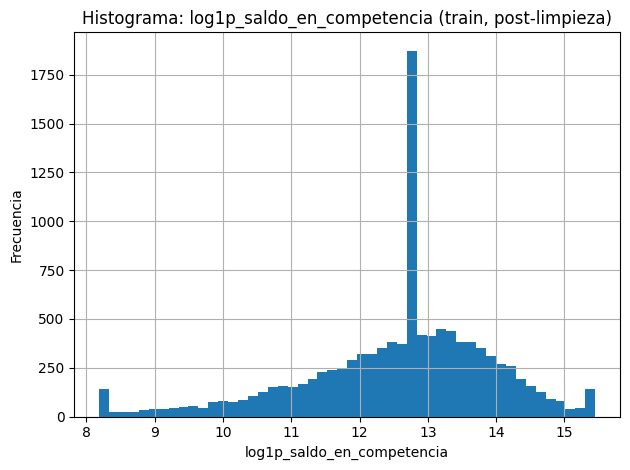

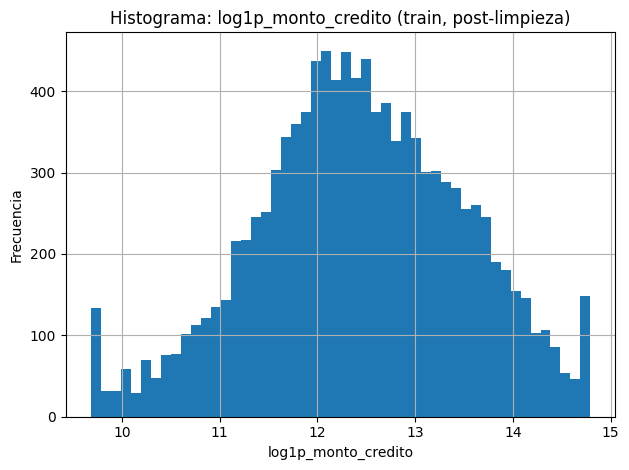

In [32]:
for c in [f"log1p_{x}" for x in money_like if f"log1p_{x}" in train_feat.columns]:
    plt.figure()
    train_feat[c].dropna().hist(bins=50)
    plt.title(f"Histograma: {c} (train, post-limpieza)")
    plt.xlabel(c)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.savefig(plots_dir + f"hist_train_post_{c}.png")
    plt.show()

In [33]:
# Correlación de features claves con la tasa (solo numéricas)
num_post = train_feat.select_dtypes(include=[np.number]).columns.tolist()
if target_col in num_post:
    corr_post = train_feat[num_post].corr(numeric_only=True)[target_col].sort_values(ascending=False)
else:
    corr_tmp = train_feat[num_post + [target_col]].corr(numeric_only=True)
    corr_post = corr_tmp[target_col].sort_values(ascending=False)

corr_post_df = corr_post.reset_index()
corr_post_df.columns = ["feature", "correlacion_con_tasa"]
corr_post_df

,feature,correlacion_con_tasa
0,tasa_interes,1.000000
1,calificacion_crediticia,0.374597
2,log1p_saldo_en_competencia,0.093278
3,ingreso_reportado,0.074494
4,cantidad_productos_activos,0.044435
5,log1p_ingreso_reportado,0.010285
6,id,-0.007344
7,saldo_en_competencia,-0.064966
8,edad,-0.124342
9,cantidad_productos_pasivos,-0.239906


Ya con la data limpia y preprocesada, podemos concluir lo siguiente según el nivel de correlación: 
1. Correlación Fuerte
    * plazo_credito: Entre más largo el plazo del crédito, menor tasa de interés (relación que no es del todo cierta en la realidad)
    * Saldo total (log): Clientes con mayor saldo total tienden a tener tasas de interés más bajas.
    * Saldo Productos Activos (log): Similar al anterior, indica que clientes con más productos activos/saldo más alto reciben tasas menores.
    * Monto Crédito (log): A mayor monto de crédito solicitado, menor la tasa (relación que tampoco es necesariamente cierta).
    * Calificación Crediticia: A mayor calificación crediticia, mayor la tasa (esto es mu curioso ya que en la realidad es lo contrario).
2. Correlación Débil:
    * El ingreso reportado, cantidad de productos activos, saldo en competencia y el id tienen una relación prácticamente nula.
3. Correlación Negativa:
    * maximo_dias_mora y saldo_productos_pasivos las cuales podrían deberse a un efecto de coilinealidad (como saldo total) o datos segmentados (tal vez los clientes con mayores días de mora son de un segmento con tasas fijas o especiales).

In [34]:
def outlier_profile(df, cols, k=10):
    rows = []
    for c in cols:
        s = df[c].dropna()
        if len(s) == 0: 
            continue
        p50 = np.percentile(s, 50)
        p99 = np.percentile(s, 99)
        if p50 != 0:
            ratio = p99 / (p50 if p50 != 0 else 1)
        else:
            ratio = np.inf
        rows.append((c, p50, p99, ratio))
    prof = pd.DataFrame(rows, columns=["col","p50","p99","p99/p50"]).sort_values("p99/p50", ascending=False)
    return prof.head(k)


outliers = outlier_profile(train_feat, [c for c in train_feat.select_dtypes(include=[np.number]).columns.tolist() if c != target_col], k=15)
outliers

,col,p50,p99,p99/p50
6,saldo_productos_pasivos,29075.000000,3.772550e+06,129.752364
3,maximo_dias_mora,13.000000,2.739075e+02,21.069808
9,saldo_en_competencia,342419.750000,5.123666e+06,14.963115
4,saldo_total,491759.000000,6.754621e+06,13.735633
10,monto_credito,246000.000000,2.656117e+06,10.797226
5,saldo_productos_activos,401201.500000,4.221517e+06,10.522187
11,plazo_credito,61.000000,3.663025e+02,6.004959
8,cantidad_productos_pasivos,1.000000,6.000000e+00,6.000000
7,cantidad_productos_activos,3.000000,1.200000e+01,4.000000
2,ingreso_reportado,86639.000000,3.061416e+05,3.533532


De las variables revisadas en la correlación anterior, el máximo de días en mora es una de las que presenta mayor cantidad de outliers.

In [35]:
# Drift rápido: diferencias de mediana > 20% entre train y test
drift_candidates = []
for c in [x for x in train_feat.select_dtypes(include=[np.number]).columns.tolist() if x in test_raw.columns and x != target_col]:
    tr = train_raw[c].dropna()
    te = test_raw[c].dropna()
    if len(tr)>0 and len(te)>0:
        med_tr = np.median(tr)
        med_te = np.median(te)
        if med_tr != 0:
            diff = (med_te - med_tr) / med_tr
            if abs(diff) > 0.2:
                drift_candidates.append((c, med_tr, med_te, diff))
drift_candidates = pd.DataFrame(drift_candidates, columns=["col","train_median","test_median","rel_diff"]).sort_values("rel_diff", ascending=False)
drift_candidates

,col,train_median,test_median,rel_diff
0,calificacion_crediticia,3.0,4.0,0.333333


El resto de variables numéricas no muestran cambios extremos de mediana.

## Feature Engineering

In [36]:
# recordamos columnas importantes
TARGET = "tasa_interes"
IDCOL = "id"

# nueva copia para modificaciones
train_df = train_feat.copy()
test_df = test_feat.copy()

Antes de proceder es importante mencionar lo siguiente:
* En EDA, el `log1p` sirvió para diagnosticar y mejorar la representación de variables monetarias; esas columnas permanecen en el set de entrenamiento y prueba.
* Para las *features* de negocio usamos ratios crudos (interpretables y eficacies con árboles).
* No creamos *log-ratios* adicionales ahora para evitar redundancias, colinealidad y pérdida de claridad sin un beneficio sustancial en el modelo de árboles seleccionado.

In [37]:
# Función de ingeniería de características
def add_business_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    eps = 1e-6 # evitamos infinitos

    # Ratios de composición
    if "saldo_total" in df and "saldo_productos_activos" in df:
        df["ratio_activos_total"] = df["saldo_productos_activos"] / (df["saldo_total"] + eps)
    if "saldo_total" in df and "saldo_productos_pasivos" in df:
        df["ratio_pasivos_total"] = df["saldo_productos_pasivos"] / (df["saldo_total"] + eps)
    if "saldo_productos_activos" in df and "saldo_productos_pasivos" in df:
        df["ratio_pasivos_activos"] = df["saldo_productos_pasivos"] / (df["saldo_productos_activos"] + eps)
    if "saldo_total" in df and "saldo_en_competencia" in df:
        df["ratio_competencia_total"] = df["saldo_en_competencia"] / (df["saldo_total"] + eps)

    # Apalancamiento / pago aproximado
    if "monto_credito" in df and "ingreso_reportado" in df:
        df["dti_monto_sobre_ingreso"] = df["monto_credito"] / (df["ingreso_reportado"] + 1.0)
    if "monto_credito" in df and "plazo_credito" in df:
        denom = (df["plazo_credito"].replace(0, np.nan) + eps)
        df["cuota_aprox"] = df["monto_credito"] / denom
        df["monto_por_mes"] = df["monto_credito"] / denom

    # Intensidad de relación
    if "cantidad_productos_activos" in df and "cantidad_productos_pasivos" in df:
        df["productos_totales"] = df["cantidad_productos_activos"] + df["cantidad_productos_pasivos"]
    if "saldo_productos_activos" in df and "cantidad_productos_activos" in df:
        df["saldo_prom_activo"] = df["saldo_productos_activos"] / (df["cantidad_productos_activos"] + 1.0)
    if "saldo_productos_pasivos" in df and "cantidad_productos_pasivos" in df:
        df["saldo_prom_pasivo"] = df["saldo_productos_pasivos"] / (df["cantidad_productos_pasivos"] + 1.0)

    # Interacciones suaves
    if "plazo_credito" in df and "calificacion_crediticia" in df:
        df["plazo_x_score"] = df["plazo_credito"] * df["calificacion_crediticia"]
    if "edad" in df and "calificacion_crediticia" in df:
        df["edad_x_score"] = df["edad"] * df["calificacion_crediticia"]
    return df

In [38]:
# Aplicamos la función de ingeniería de características
train_eng = add_business_features(df=train_feat)
test_eng = add_business_features(df=test_feat)

In [39]:
# ordenamos las columnas
new_cols = sorted(set(train_eng.columns) - set(train_feat.columns))
new_cols[:10], len(new_cols)

(['cuota_aprox',
  'dti_monto_sobre_ingreso',
  'edad_x_score',
  'monto_por_mes',
  'plazo_x_score',
  'productos_totales',
  'ratio_activos_total',
  'ratio_competencia_total',
  'ratio_pasivos_activos',
  'ratio_pasivos_total'],
 12)

### Modelado con CV

In [40]:
# Separamos en las variables para el modelado
X = train_eng.drop(columns=[TARGET])
y = train_eng[TARGET].astype(float)
X_test_final = test_eng.copy()

In [41]:
# Tipos
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]
for drop_c in [IDCOL]:
    if drop_c in num_cols: num_cols.remove(drop_c)
    if drop_c in cat_cols: cat_cols.remove(drop_c)

In [42]:
# Preprocesamiento
numeric_standard = Pipeline([("imp", SimpleImputer(strategy="median")),
                             ("scaler", StandardScaler())])
numeric_passthrough = Pipeline([("imp", SimpleImputer(strategy="median"))])
categorical_enc = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False))])

preproc_linear = ColumnTransformer([("num", numeric_standard, num_cols),
                                    ("cat", categorical_enc, cat_cols)],
                                   remainder="drop")
preproc_trees  = ColumnTransformer([("num", numeric_passthrough, num_cols),
                                    ("cat", categorical_enc, cat_cols)],
                                   remainder="drop")

In [43]:
# Modelos y grids reducidos
models = {
    "DummyMedian": Pipeline([("prep", preproc_trees),
                             ("model", DummyRegressor(strategy="median"))]),
    "ElasticNet": Pipeline([("prep", preproc_linear),
                            ("model", ElasticNet(max_iter=3000, random_state=42))]),
    "HGBR": Pipeline([("prep", preproc_trees),
                      ("model", HistGradientBoostingRegressor(random_state=42))]),
}

param_grids = {
    "ElasticNet": {
        "model__alpha": [0.05, 0.1, 0.5],
        "model__l1_ratio": [0.1, 0.5, 0.9]
    },
    "HGBR": {
        "model__learning_rate": [0.05, 0.1],
        "model__max_leaf_nodes": [31, 63],
        "model__max_depth": [None, 6],
        "model__l2_regularization": [0.0, 1.0]
    }
}

In [44]:
# Generador de validación cruzada
cv = KFold(n_splits=3, shuffle=True, random_state=42)
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

In [45]:
# Evaluación
cv_rows = []
best_estimators = {}

for name, pipe in models.items():
    if name == "DummyMedian":
        # Fit directo + score holdout estilo CV interno rápido
        scores = []
        for tr_idx, te_idx in cv.split(X):
            Xtr, Xte = X.iloc[tr_idx], X.iloc[te_idx]
            ytr, yte = y.iloc[tr_idx], y.iloc[te_idx]
            m = pipe.fit(Xtr, ytr)
            pred = m.predict(Xte)
            scores.append(mean_squared_error(yte, pred, squared=False))
        best_estimators[name] = pipe.fit(X, y)
        cv_rows.append({"model": name, "best_params": {}, "cv_rmse_mean": float(np.mean(scores)), "cv_rmse_std": float(np.std(scores))})
    else:
        grid = GridSearchCV(pipe, param_grids[name], scoring=rmse_scorer, cv=cv, n_jobs=1, verbose=0)
        grid.fit(X, y)
        best_estimators[name] = grid.best_estimator_
        cv_rows.append({"model": name, "best_params": grid.best_params_, "cv_rmse_mean": float(-grid.best_score_), "cv_rmse_std": float(grid.cv_results_['std_test_score'][grid.best_index_])})

cv_df = pd.DataFrame(cv_rows).sort_values("cv_rmse_mean")
cv_df

,model,best_params,cv_rmse_mean,cv_rmse_std
2,HGBR,"{'model__l2_regularization': 1.0, 'model__lear...",1.487720,0.037385
1,ElasticNet,"{'model__alpha': 0.05, 'model__l1_ratio': 0.9}",2.121460,0.036350
0,DummyMedian,{},4.441029,0.032074


In [46]:
# Mejor modelo
best_name = cv_df.iloc[0]["model"]
best_model = best_estimators[best_name]

In [47]:
# Holdout 20% para diagnósticos
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2025, shuffle=True)
best_model.fit(X_train, y_train)
val_pred = best_model.predict(X_val)

rmse_val = mean_squared_error(y_val, val_pred, squared=False)
mae_val  = mean_absolute_error(y_val, val_pred)
r2_val   = r2_score(y_val, val_pred)

metrics_val_df = pd.DataFrame([{"mejor_modelo": best_name, "val_RMSE": rmse_val, "val_MAE": mae_val, "val_R2": r2_val}])
metrics_val_df

,mejor_modelo,val_RMSE,val_MAE,val_R2
0,HGBR,1.505073,0.969011,0.887994


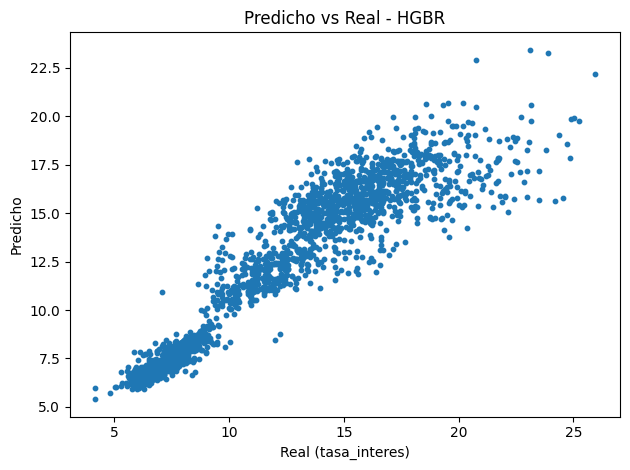

In [48]:
# Predicho vs Real
plt.figure()
plt.scatter(y_val, val_pred, s=10)
plt.xlabel("Real (tasa_interes)")
plt.ylabel("Predicho")
plt.title(f"Predicho vs Real - {best_name}")
plt.tight_layout()
plt.savefig(plots_dir + f"scatter_real_vs_pred_{best_name}.png")
plt.show()

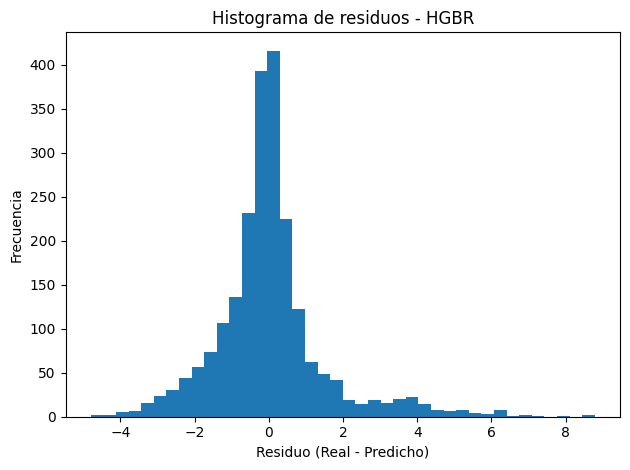

In [49]:
# Residuos
residuals = y_val - val_pred
plt.figure()
plt.hist(residuals, bins=40)
plt.xlabel("Residuo (Real - Predicho)")
plt.ylabel("Frecuencia")
plt.title(f"Histograma de residuos - {best_name}")
plt.tight_layout()
plt.savefig(plots_dir + f"hist_residuos_{best_name}.png")
plt.show()

In [50]:
# Importancias por permutación (muestras para rapidez)
def get_feature_names(preprocessor: ColumnTransformer) -> list:
    names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == 'remainder' and trans == 'drop':
            continue
        if hasattr(trans, 'named_steps'):
            last = list(trans.named_steps.values())[-1]
            if isinstance(last, OneHotEncoder):
                names.extend(list(last.get_feature_names_out(cols)))
            else:
                names.extend(cols)
        elif isinstance(trans, OneHotEncoder):
            names.extend(list(trans.get_feature_names_out(cols)))
        else:
            names.extend(cols if isinstance(cols, (list, tuple, np.ndarray)) else [cols])
    return names

prep = best_model.named_steps['prep']
feature_names = get_feature_names(prep)

In [51]:
# muestreo para acelerar
val_sample = min(2000, len(X_val))
Xv = X_val.iloc[:val_sample].copy()
yv = y_val.iloc[:val_sample].copy()

perm = permutation_importance(
    best_model, Xv, yv,
    n_repeats=5, random_state=2025,
    scoring="neg_mean_squared_error"
)

feature_names = Xv.columns  # <-- columnas originales (crudas)
imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance", ascending=False)
imp_path = "../data/feature_importances_permutation.csv"
imp_df.to_csv(imp_path, index=False)

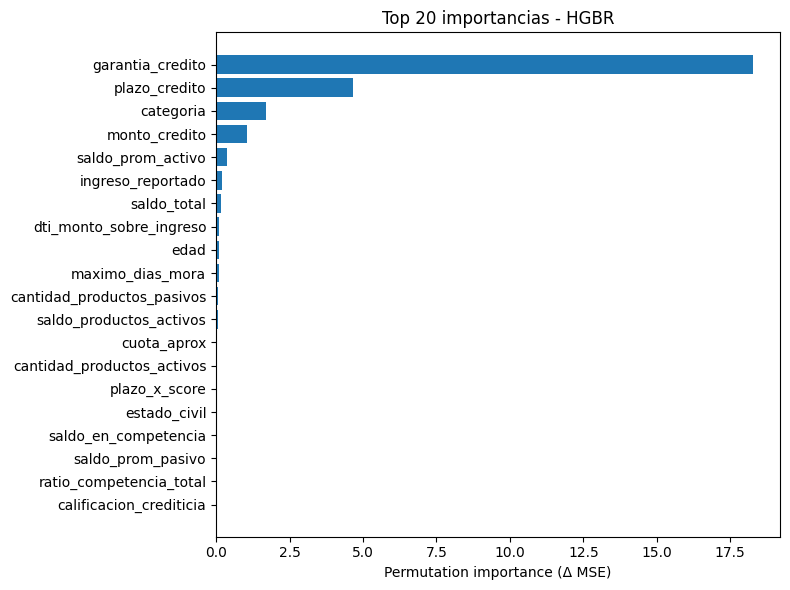

In [52]:
# Plot top 20 importancias
topK = 20
top_imp = imp_df.head(topK)
plt.figure(figsize=(8, 6))
plt.barh(range(len(top_imp)), top_imp["importance"][::-1])
plt.yticks(range(len(top_imp)), top_imp["feature"][::-1])
plt.xlabel("Permutation importance (Δ MSE)")
plt.title(f"Top {topK} importancias - {best_name}")
plt.tight_layout()
plt.savefig(plots_dir + f"perm_importance_top{topK}_{best_name}.png")
plt.show()

In [53]:
# Fairness por subgrupos en holdout
def group_metrics(df_val, y_true, y_pred, col):
    out = []
    if col not in df_val.columns:
        return pd.DataFrame(columns=["grupo","n","RMSE","MAE"])
    pred_s = pd.Series(y_pred, index=y_true.index)
    for g, idx in df_val.groupby(col).groups.items():
        yt = y_true.loc[idx]
        yp = pred_s.loc[idx]
        out.append({"grupo": g, "n": len(idx), "RMSE": mean_squared_error(yt, yp, squared=False), "MAE": mean_absolute_error(yt, yp)})
    return pd.DataFrame(out).sort_values("RMSE")

In [56]:
# Aplicando la función de métricas
X_val_df = X_val.copy()
fair_tables = {}
for gcol in ["categoria", "genero", "estado_civil", "garantia_credito"]:
    if gcol in X_val_df.columns:
        tdf = group_metrics(X_val_df, y_val, val_pred, gcol)
        fair_tables[gcol] = tdf
        tdf.to_csv('../data/' + f"fairness_{gcol}.csv", index=False)
        print(tdf)

     grupo     n      RMSE       MAE
2  privada   142  0.721815  0.573787
1  premier   661  1.258211  0.803454
0   optima  1407  1.661851  1.086677
       grupo     n      RMSE       MAE
1  masculino  1139  1.478705  0.948653
0   femenino  1071  1.532618  0.990662
        grupo     n      RMSE       MAE
3       viudo    93  1.444166  0.878278
1  divorciado   228  1.477753  0.922992
2     soltero   532  1.506881  0.956190
0      casado  1357  1.512982  0.987988
                         grupo     n      RMSE       MAE
3           fiduciaria_prendas   147  0.307177  0.229072
5                      prendas    61  0.315314  0.247133
4                  hipotecaria   466  0.474814  0.319210
2  fiduciaria_bienes_inmuebles    58  0.543173  0.418094
0               autoliquidable   144  0.608145  0.489147
1                   fiduciaria  1334  1.899031  1.386303


In [57]:
# Entrenar en todo el train y predecir test
best_model.fit(X, y)
test_pred = best_model.predict(X_test_final)

In [58]:
# Clip y redondeo
y_min, y_max = float(train_eng[TARGET].min()), float(train_eng[TARGET].max())
test_pred_clip = np.clip(test_pred, y_min, y_max)
test_pred_2d = np.round(test_pred_clip, 2)

In [59]:
# resultados.csv
res_df = pd.DataFrame({"id": X_test_final[IDCOL].values, "tasa_interes": test_pred_2d})
res_path = "../data/resultados.csv"
res_df.to_csv(res_path, index=False)

In [61]:
# Guardar tablas clave
cv_path = "../data/model_cv_summary.csv"
cv_df = pd.DataFrame(cv_rows).sort_values("cv_rmse_mean")
cv_df.to_csv(cv_path, index=False)

metrics_path = "../data/metrics_holdout.csv"
metrics_val_df.to_csv(metrics_path, index=False)

In [63]:
# Baseline Dummy (mediana)
dummy = DummyRegressor(strategy="median")
# Para que use las mismas columnas post-preprocesamiento, simplemente se entrena sobre y (no necesita X transformado)
dummy.fit(np.zeros((len(y_train), 1)), y_train)  # hack: ignora X
dummy_pred = np.repeat(dummy.predict([[0]]), len(y_val))  # vector constante

rmse_dummy = mean_squared_error(y_val, dummy_pred, squared=False)
mae_dummy  = mean_absolute_error(y_val, dummy_pred)

In [64]:
# Guardar comparativa
comp_df = pd.DataFrame([
    {"modelo": "DummyMedian", "RMSE": rmse_dummy, "MAE": mae_dummy},
    {"modelo": "HGBR(default)", "RMSE": mean_squared_error(y_val, best_model.predict(X_val), squared=False),
     "MAE": mean_absolute_error(y_val, best_model.predict(X_val))}
])
comp_path = "../data/holdout_comparacion_baseline.csv"
comp_df.to_csv(comp_path, index=False)

In [65]:
# Gráficos diagnósticos para HGBR
val_pred = best_model.predict(X_val)
residuals = y_val - val_pred

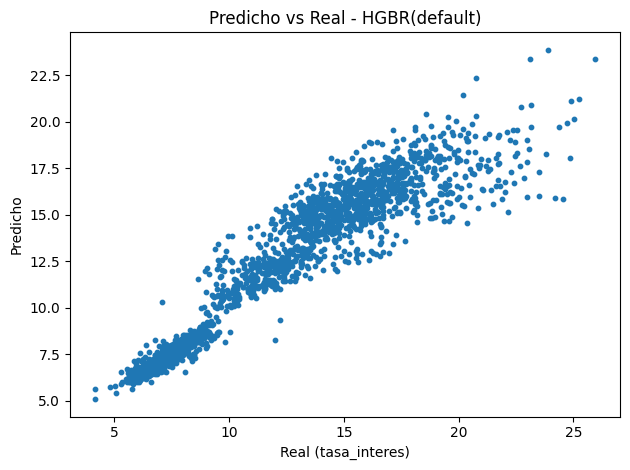

In [67]:
# Scatter real vs pred
plt.figure()
plt.scatter(y_val, val_pred, s=10)
plt.xlabel("Real (tasa_interes)")
plt.ylabel("Predicho")
plt.title("Predicho vs Real - HGBR(default)")
plt.tight_layout()
plt.savefig(plots_dir + "scatter_real_vs_pred_HGBR.png")
plt.show()

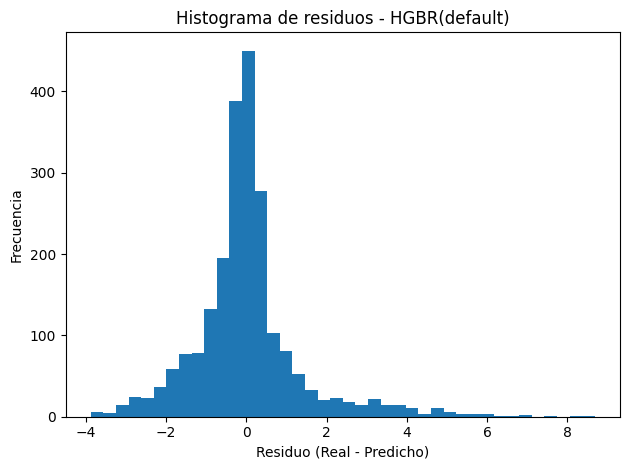

In [68]:
# Hist residuals
plt.figure()
plt.hist(residuals, bins=40)
plt.xlabel("Residuo (Real - Predicho)")
plt.ylabel("Frecuencia")
plt.title("Histograma de residuos - HGBR(default)")
plt.tight_layout()
plt.savefig(plots_dir + "hist_residuos_HGBR.png")
plt.show()

In [69]:
# Fairness por 'categoria' y 'garantia_credito' (si existen en X_val)
def group_metrics(df_val, y_true, y_pred, col):
    out = []
    if col not in df_val.columns:
        return pd.DataFrame(columns=["grupo","n","RMSE","MAE"])
    pred_s = pd.Series(y_pred, index=y_true.index)
    for g, idx in df_val.groupby(col).groups.items():
        yt = y_true.loc[idx]
        yp = pred_s.loc[idx]
        out.append({"grupo": g, "n": len(idx), "RMSE": mean_squared_error(yt, yp, squared=False), "MAE": mean_absolute_error(yt, yp)})
    return pd.DataFrame(out).sort_values("RMSE")

In [71]:
# Aplicamos función para métricas
X_val_df = X_val.copy()
fair_cols = [c for c in ["categoria", "garantia_credito"] if c in X_val_df.columns]
fair_files = []
for gcol in fair_cols:
    tdf = group_metrics(X_val_df, y_val, val_pred, gcol)
    fp = f"../data/fairness_{gcol}.csv"
    tdf.to_csv(fp, index=False)
    fair_files.append(fp)